# Exploratory analysis

In [1]:
import json
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
nltk.download("punkt")

# File paths
json_path = Path("../outputs/fomc_minutes.json")
output_path = Path("../outputs/fomc_text_statistics.csv")

# Load JSON with texts
with json_path.open("r", encoding="utf-8") as file:
    data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame(data)

# Date processing
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# Feature extraction function
def extract_features(text):
    n_chars = len(text)
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    
    n_words = len(words)
    n_sentences = len(sentences)
    
    avg_word_length = sum(len(w) for w in words) / n_words if n_words else 0
    avg_sentence_length_words = n_words / n_sentences if n_sentences else 0
    avg_sentence_length_chars = n_chars / n_sentences if n_sentences else 0
    
    vocab = set(words)
    vocab_size = len(vocab)
    ttr = vocab_size / n_words if n_words else 0
    
    word_counts = Counter(words)
    hapax_legomena = sum(1 for word, count in word_counts.items() if count == 1)
    hapax_ratio = hapax_legomena / n_words if n_words else 0
    
    return pd.Series([
        n_chars, n_words, n_sentences, avg_word_length,
        avg_sentence_length_words, avg_sentence_length_chars,
        vocab_size, ttr, hapax_legomena, hapax_ratio
    ])

# Apply the function to the text column
df[
    [
        "n_chars", "n_words", "n_sentences", "avg_word_length",
        "avg_sentence_length_words", "avg_sentence_length_chars",
        "vocab_size", "type_token_ratio", "hapax_legomena", "hapax_ratio"
    ]
] = df["text"].apply(extract_features)

# Create title based on date, if not present
df["title"] = df["date"].dt.strftime("%Y-%m-%d")

# Keep only necessary columns
df = df[[
    "title", "year", "n_chars", "n_words", "n_sentences", "avg_word_length",
    "avg_sentence_length_words", "avg_sentence_length_chars",
    "vocab_size", "type_token_ratio", "hapax_legomena", "hapax_ratio"
]]

# Save the result
df.to_csv(output_path, index=False, encoding="utf-8")

print(f"Statistics saved: {output_path}")
print(df.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Statistics saved: ..\outputs\fomc_text_statistics.csv
        title  year  n_chars  n_words  n_sentences  avg_word_length  \
0  2000-02-02  2000  22032.0   3674.0        114.0         5.074306   
1  2000-03-21  2000  19490.0   3223.0        106.0         5.130624   
2  2000-05-16  2000  21395.0   3545.0        114.0         5.109168   
3  2000-06-28  2000  23560.0   3923.0        115.0         5.079276   
4  2000-08-22  2000  24705.0   4050.0        125.0         5.181481   

   avg_sentence_length_words  avg_sentence_length_chars  vocab_size  \
0                  32.228070                 193.263158       990.0   
1                  30.405660                 183.867925       860.0   
2                  31.096491                 187.675439       973.0   
3                  34.113043                 204.869565       989.0   
4                  32.400000                 197.640000       992.0   

   type_token_ratio  hapax_legomena  hapax_ratio  
0          0.269461           554.0     0

c:\Users\olegv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\olegv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\olegv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\olegv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

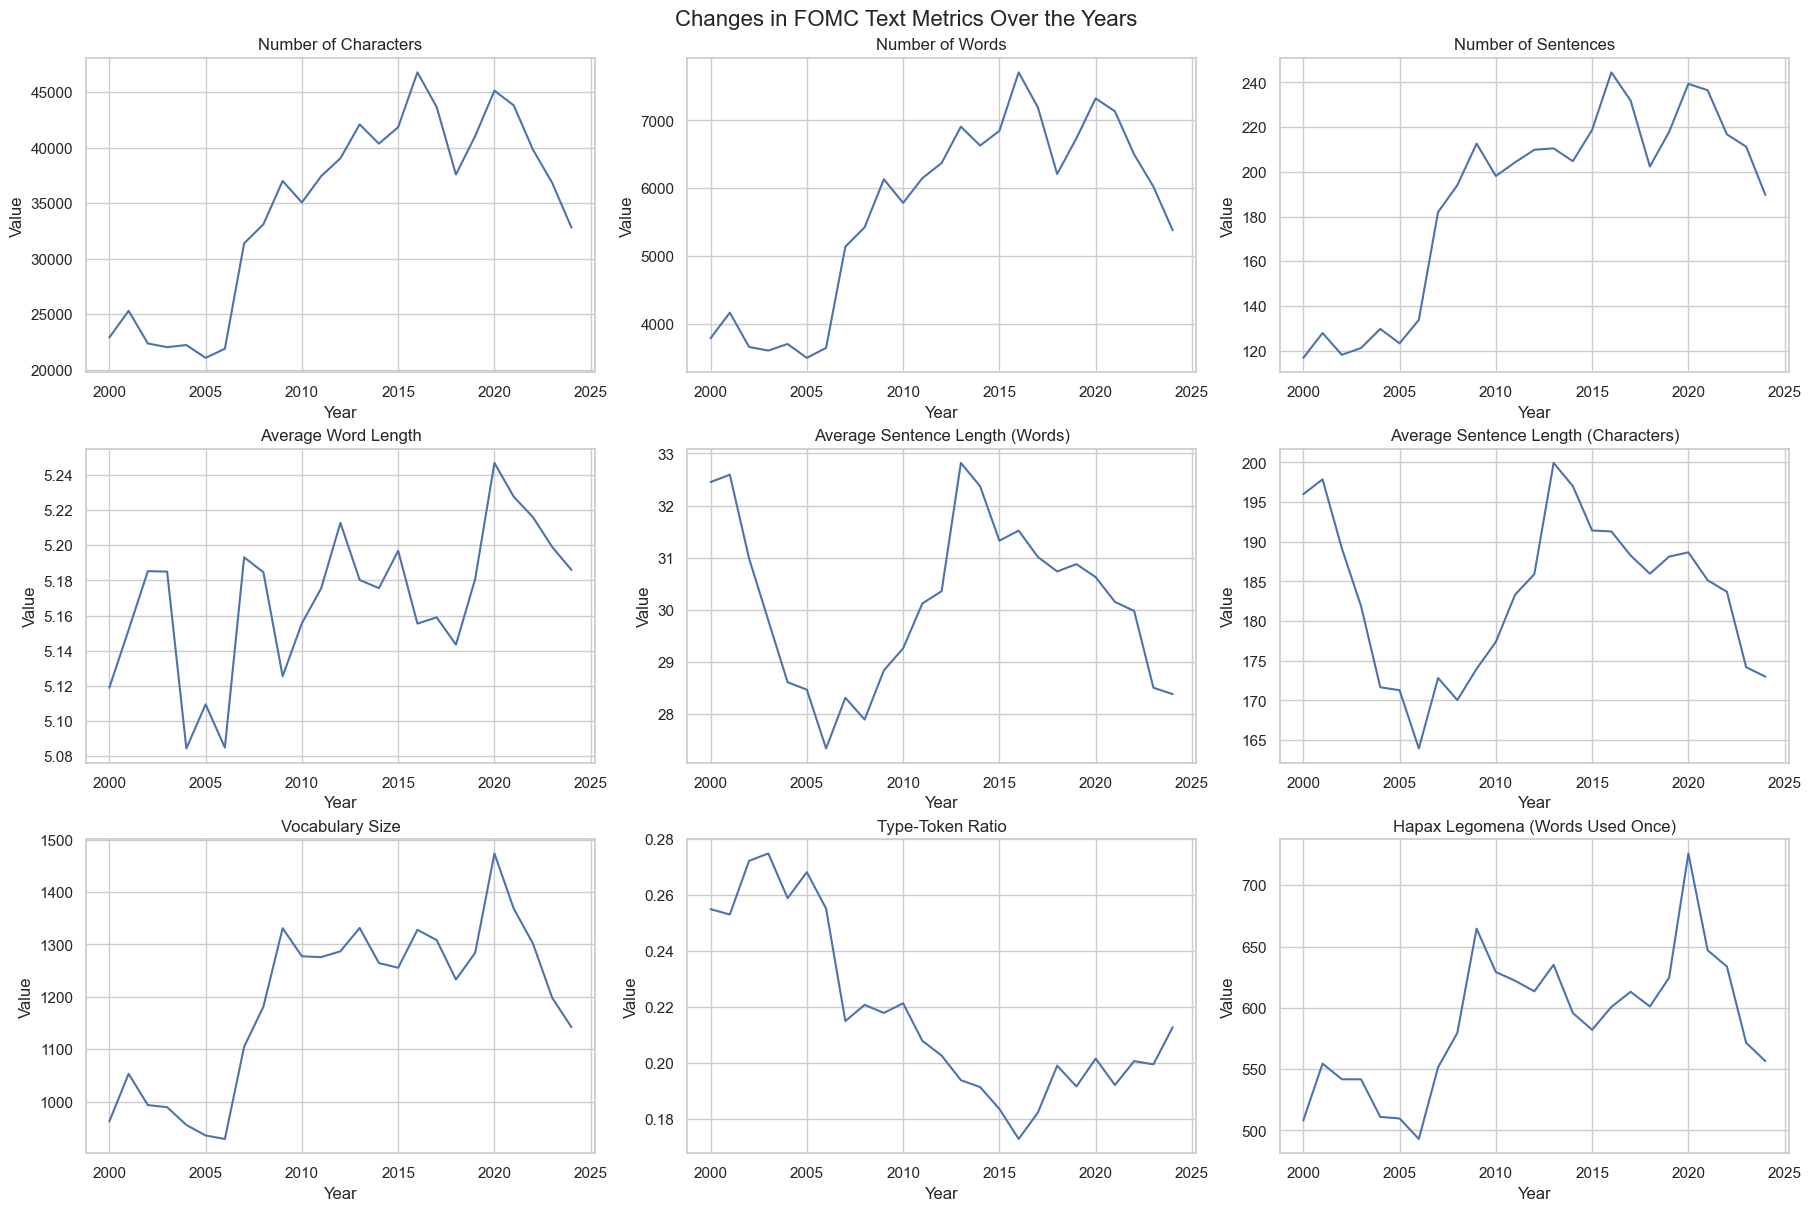

In [9]:
# Plot style settings 
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# List of metrics to display
metrics = [
    "n_chars",
    "n_words",
    "n_sentences",
    "avg_word_length",
    "avg_sentence_length_words",
    "avg_sentence_length_chars",
    "vocab_size",
    "type_token_ratio",
    "hapax_legomena"
]

# Человеческие названия для графиков
metric_titles = {
    "n_chars": "Number of Characters",
    "n_words": "Number of Words",
    "n_sentences": "Number of Sentences",
    "avg_word_length": "Average Word Length",
    "avg_sentence_length_words": "Average Sentence Length (Words)",
    "avg_sentence_length_chars": "Average Sentence Length (Characters)",
    "vocab_size": "Vocabulary Size",
    "type_token_ratio": "Type-Token Ratio",
    "hapax_legomena": "Hapax Legomena (Words Used Once)"
}

# Group by year: take average values
yearly_stats = df.groupby("year")[metrics].mean().reset_index()

# Create one large plot with subplots (3 columns)
n_cols = 3
n_rows = (len(metrics) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), constrained_layout=True)

# Fill each subplot
for i, metric in enumerate(metrics):
    row, col = divmod(i, n_cols)
    ax = axes[row][col] if n_rows > 1 else axes[col]
    sns.lineplot(data=yearly_stats, x="year", y=metric, ax=ax)
    ax.set_title(metric_titles.get(metric, metric.replace("_", " ").title()))
    ax.set_xlabel("Year")
    ax.set_ylabel("Value")

# If there are empty cells left — remove them
for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    ax = axes[row][col] if n_rows > 1 else axes[col]
    ax.axis("off")

plt.suptitle("Changes in FOMC Text Metrics Over the Years", fontsize=16)
plt.show()
